# Probabilistic Graphical Models

Los modelos gráficos probabilísticos son una herramienta poderosa en el aprendizaje automático para representar y razonar con incertidumbre y relaciones complejas. Un ejemplo común y relativamente simple es el modelo de Bayes, que se utiliza para representar relaciones probabilísticas entre variables.

## 1. Introduction

Imagina que estamos construyendo un sistema para diagnosticar una enfermedad basado en dos síntomas: fiebre y tos. Queremos calcular la probabilidad de la enfermedad dada la presencia o ausencia de estos síntomas.

Usaremos la biblioteca pgmpy, que está preparada para trabajar con modelos gráficos probabilísticos.

Comenzamos creando el modelo de Bayes. El modelo de Bayes es un modelo gráfico probabilístico que representa las relaciones probabilísticas entre variables. En este caso, tenemos dos variables: fiebre y tos. 

En este caso, fiebre y fTos son nodos que representan los síntomas, y Enfermedad es el nodo que representa la enfermedad. Las flechas indican que tanto la fiebre como la tos son causas potenciales de la enfermedad.

<br>
<img src="data/g2.png" width="600" />

In [1]:
from pgmpy.models import BayesianModel
from pgmpy.factors.discrete import TabularCPD

# Crear un modelo de Bayes
modelo = BayesianModel([('Fiebre', 'Enfermedad'), ('Tos', 'Enfermedad')])


INFO:numexpr.utils:Note: NumExpr detected 20 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.
c:\Users\icira\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Podemos representar visualmente el modelo de Bayes utilizando las biblioteca networkx y matplotlib.

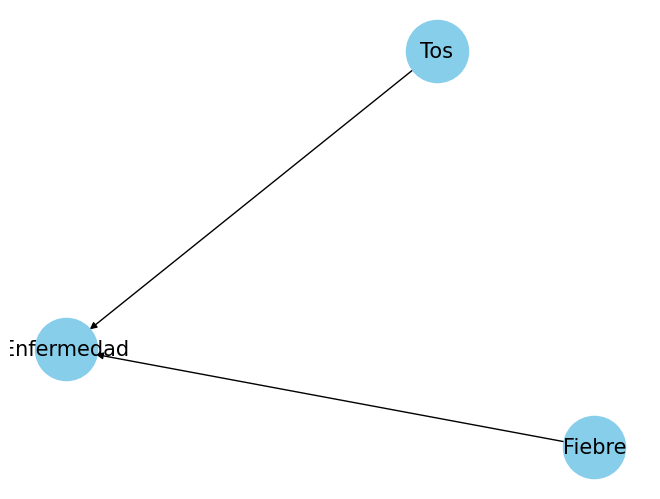

In [3]:
import networkx as nx
import matplotlib.pyplot as plt

# Crear un grafo dirigido
G = nx.DiGraph()

# Añadir los nodos
G.add_node('Fiebre')
G.add_node('Tos')
G.add_node('Enfermedad')

# Añadir las aristas dirigidas
G.add_edge('Fiebre', 'Enfermedad')
G.add_edge('Tos', 'Enfermedad')

# Dibujar el grafo
pos = nx.spring_layout(G)  # Posiciones de los nodos en un diseño de resorte
nx.draw(G, pos, with_labels=True, node_color='skyblue', node_size=2000, edge_color='black', linewidths=1, font_size=15)

# Mostrar el grafo
plt.show()


A continuación definimos las tablas de probabilidad condicional (CPT) para cada nodo.

Cada nodo en un modelo de Bayes tiene asociada una CPT, que especifica la probabilidad de cada estado posible de ese nodo, dado el estado de sus nodos padres (es decir, los nodos de los cuales depende directamente en el grafo). En un modelo de Bayes, cada variable (o nodo) se considera como una variable aleatoria con una distribución de probabilidad específica.

In [4]:
# CPT para Fiebre
cpd_fiebre = TabularCPD(variable='Fiebre', variable_card=2, values=[[0.7], [0.3]])
# CPT para Tos
cpd_tos = TabularCPD(variable='Tos', variable_card=2, values=[[0.6], [0.4]])
# CPT para Enfermedad
cpd_enfermedad = TabularCPD(variable='Enfermedad', variable_card=2, 
                            values=[[0.9, 0.6, 0.7, 0.1],
                                    [0.1, 0.4, 0.3, 0.9]],
                            evidence=['Fiebre', 'Tos'],
                            evidence_card=[2, 2])


Aquí, variable_card representa el número de estados posibles para la variable (por ejemplo, fiebre sí/no), y values son las probabilidades. En el caso de Enfermedad, depende de Fiebre y Tos.

Por último asignamos las CPTs al modelo:

In [5]:
modelo.add_cpds(cpd_fiebre, cpd_tos, cpd_enfermedad)

Con todo lo anterior definido, realizamos consultas en el modelo para inferir probabilidades. Por ejemplo, calcular la probabilidad de enfermedad dado que el paciente tiene fiebre pero no tos.

In [6]:
from pgmpy.inference import VariableElimination

inference = VariableElimination(modelo)
prob_enfermedad = inference.query(variables=['Enfermedad'], evidence={'Fiebre': 1, 'Tos': 0})
print(prob_enfermedad)


+---------------+-------------------+
| Enfermedad    |   phi(Enfermedad) |
+===============+===================+
| Enfermedad(0) |            0.7000 |
+---------------+-------------------+
| Enfermedad(1) |            0.3000 |
+---------------+-------------------+


## 2. Iris Dataset

Para un ejemplo más avanzado de modelos gráficos probabilísticos, podemos usar el dataset clásico de Iris. Este dataset contiene 150 muestras de flores de iris, cada una con cuatro características: longitud y ancho del sépalo y longitud y ancho del pétalo. Las muestras pertenecen a tres especies diferentes de flores de iris: Iris setosa, Iris virginica e Iris versicolor.

Vamos a construir un modelo de Bayes para clasificar las especies de las flores de iris basándonos en estas características. Usaremos pgmpy para el modelo y scikit-learn para cargar el dataset.

Importamo el dataset y lo preparamos para su uso:

In [7]:
from sklearn import datasets
import pandas as pd

# Cargar el dataset de Iris
iris = datasets.load_iris()
iris_data = pd.DataFrame(iris.data, columns=iris.feature_names)
iris_data['species'] = iris.target

# Mapear los números a los nombres de las especies para mayor claridad
species_mapping = dict(zip(range(3), iris.target_names))
iris_data['species'] = iris_data['species'].map(species_mapping)

iris_data.head()


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


Vamos a asumir algunas dependencias simples entre las variables. Por ejemplo, podríamos asumir que la longitud y el ancho del sépalo son independientes entre sí, dada la especie, y lo mismo para los pétalos.

In [8]:
from pgmpy.models import BayesianModel
from pgmpy.estimators import MaximumLikelihoodEstimator

# Definir la estructura del modelo
modelo = BayesianModel([('species', 'sepal length (cm)'), 
                        ('species', 'sepal width (cm)'),
                        ('species', 'petal length (cm)'), 
                        ('species', 'petal width (cm)')])

# Aprender las CPTs a partir de los datos
modelo.fit(iris_data, estimator=MaximumLikelihoodEstimator)

Ahora, podemos usar el modelo para hacer inferencias. Por ejemplo, podemos predecir la especie dada cierta información sobre las dimensiones de una flor.
El siguiente código te dará la distribución de probabilidad de la especie de la flor dadas las medidas del pétalo.

In [9]:
from pgmpy.inference import VariableElimination

# Crear un objeto de inferencia
inferencia = VariableElimination(modelo)

# Ejemplo: predecir la especie dada la longitud y el ancho del pétalo
resultado = inferencia.query(variables=['species'], 
                             evidence={'petal length (cm)': 5.0, 'petal width (cm)': 1.5})
print(resultado)


+---------------------+----------------+
| species             |   phi(species) |
+=====================+================+
| species(setosa)     |         0.0000 |
+---------------------+----------------+
| species(versicolor) |         0.6250 |
+---------------------+----------------+
| species(virginica)  |         0.3750 |
+---------------------+----------------+


## 3. Heart Disease Dataset

Para un ejemplo más complejo, podemos utilizar el dataset de "Heart Disease" disponible en el repositorio UCI Machine Learning. Este dataset contiene varias características clínicas y de laboratorio de pacientes y se utiliza comúnmente para predecir la presencia de enfermedades cardíacas.

El dataset contiene las siguientes columnas:

1. age: Edad del paciente en años.
2. sex: Sexo del paciente.
    - 1 representa 'masculino'
    - 0 representa 'femenino'.
3. cp (chest pain type): Tipo de dolor en el pecho experimentado por el paciente.
    - 1: Angina típica (dolor en el pecho relacionado con la disminución del suministro de sangre al corazón)
    - 2: Angina atípica (dolor en el pecho no directamente relacionado con el corazón)
    - 3: Dolor no anginoso (generalmente no relacionado con el corazón)
    - 4: Asintomático (sin síntomas de dolor en el pecho).
4. trestbps (resting blood pressure): Presión arterial en reposo medida en mm Hg (milímetros de mercurio) al ingreso al hospital.
5. chol (serum cholestoral): Nivel de colesterol sérico en mg/dl (miligramos por decilitro).
6. fbs (fasting blood sugar): Nivel de azúcar en sangre en ayunas.
    - 1 si el nivel de azúcar en sangre en ayunas es mayor a 120 mg/dl
    - 0 si es menor a 120 mg/dl.
7. restecg (resting electrocardiographic results): Resultados del electrocardiograma en reposo.
    - 0: Normal
    - 1: Anomalías en la onda ST-T (inversiones de la onda T y/o elevación o depresión del ST > 0.05 mV)
    - 2: Hipertrofia ventricular izquierda probable o definitiva según los criterios de Estes.
8. thalach (maximum heart rate achieved): Máxima frecuencia cardíaca alcanzada.
9. exang (exercise induced angina): Angina inducida por el ejercicio.
    - 1: Sí
    - 0: No.
10. oldpeak (ST depression induced by exercise relative to rest): Depresión del segmento ST inducida por el ejercicio en comparación con el reposo, medida en milímetros.
11. slope (the slope of the peak exercise ST segment): La pendiente del segmento ST del ejercicio máximo.
    - 1: Ascendente
    - 2: Plana
    - 3: Descendente.
12. ca (number of major vessels colored by flourosopy): Número de vasos principales (0-3) coloreados por fluoroscopia.
13. thal (thalassemia): Una anormalidad de la sangre llamada talasemia.
    - 3: Normal
    - 6: Defecto fijo
    - 7: Defecto reversible.
14. num (diagnosis of heart disease): Diagnóstico de enfermedad cardíaca (el atributo objetivo).
    - 0: Menos de 50% de estrechamiento de los vasos principales
    - 1-4: Diferentes grados de estrechamiento mayor al 50%.

In [10]:
import pandas as pd

# URL del dataset
url = "http://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"

# Nombres de las columnas, según la descripción del dataset
column_names = ["age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", 
                "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num"]

# Cargar el dataset
heart_data = pd.read_csv(url, names=column_names)

# Preprocesamiento básico: Convertir valores faltantes codificados como '?' a NaN
heart_data = heart_data.replace('?', pd.NA)

# Convertir columnas a números
heart_data = heart_data.apply(pd.to_numeric)

# Visualizar las primeras filas del dataset
heart_data.head()


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


Construiremos un modelo de Bayes para predecir la presencia de enfermedades cardíacas ('num') basándonos en otras variables clínicas. La elección de las dependencias entre las variables dependerá en gran medida de conocimientos médicos y estadísticos. Para simplificar, elegiremos algunas dependencias plausibles.

In [ ]:
from pgmpy.models import BayesianModel
from pgmpy.estimators import MaximumLikelihoodEstimator

# Definir la estructura del modelo
modelo_heart = BayesianModel([('age', 'num'), 
                              ('sex', 'num'), 
                              ('cp', 'num'), 
                              ('trestbps', 'num'),
                              ('chol', 'num'), 
                              ('fbs', 'num'), 
                              ('restecg', 'num'), 
                              ('thalach', 'num'),
                              ('exang', 'num'), 
                              ('oldpeak', 'num'), 
                              ('slope', 'num'),
                              ('ca', 'num'), 
                              ('thal', 'num')])

# Aprender las CPTs a partir de los datos
modelo_heart.fit(heart_data, estimator=MaximumLikelihoodEstimator)


En la realidad, pudiera haber muchas más dependencias entre las variables, y el modelo de Bayes puede ser un poco limitado. Sin embargo, es un buen punto de partida para el modelado de relaciones complejas entre variables.

En la práctica, conforme aumenta el número de relaciones, el tamaño del modelo crece exponentealmente. Por lo tanto, es importante elegir cuidadosamente las dependencias entre las variables.

En este caso concreto, las variables definidas resultan en un modelo de más de 3 Tb de tamaño. Por lo tanto, no podemos crear el modelo completo. En su lugar, vamos a crear un modelo parcial que incluya las variables más importantes.

In [12]:
from pgmpy.models import BayesianModel
from pgmpy.estimators import MaximumLikelihoodEstimator

# Definir una estructura de modelo más simple
modelo_heart = BayesianModel([('age', 'num'), 
                              ('sex', 'num'), 
                              ('cp', 'num'), 
                              ('trestbps', 'num')])  # Solo algunas variables para simplificar

# Aprender las CPTs a partir de los datos (puede tomar algo de tiempo dependiendo del tamaño del dataset)
modelo_heart.fit(heart_data, estimator=MaximumLikelihoodEstimator)


Ahora, podemos usar el modelo para hacer inferencias, como predecir la probabilidad de enfermedad cardíaca dados ciertos factores.
El siguiente código te dará la distribución de probabilidad de tener una enfermedad cardíaca dadas las características del paciente.

In [13]:
from pgmpy.inference import VariableElimination

# Crear un objeto de inferencia para el modelo
inferencia_heart = VariableElimination(modelo_heart)

# Ejemplo: predecir la enfermedad cardíaca dadas ciertas características del paciente
# Nota: Asegúrate de usar valores dentro del rango de los datos para cada variable
resultado = inferencia_heart.query(variables=['num'], 
                                   evidence={'age': 50, 'sex': 1, 'cp': 2, 'trestbps': 130})
print(resultado)


+--------+------------+
| num    |   phi(num) |
+========+============+
| num(0) |     0.2000 |
+--------+------------+
| num(1) |     0.2000 |
+--------+------------+
| num(2) |     0.2000 |
+--------+------------+
| num(3) |     0.2000 |
+--------+------------+
| num(4) |     0.2000 |
+--------+------------+


# Variational Inference

La inferencia variacional se utiliza para aproximar distribuciones de probabilidad complejas mediante la optimización de distribuciones más simples. Es especialmente útil en modelos como los Bayesianos, donde la inferencia exacta es computacionalmente costosa o imposible.

## 1. Introducción

Vamos a crear un ejemplo sencillo con una distribución de datos (normal) y usaremos inferencia variacional para aproximarla con otra distribución.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

Supongamos que tenemos una distribución normal con una media y desviación estándar conocidas. Esta será la distribución que queremos aproximar.

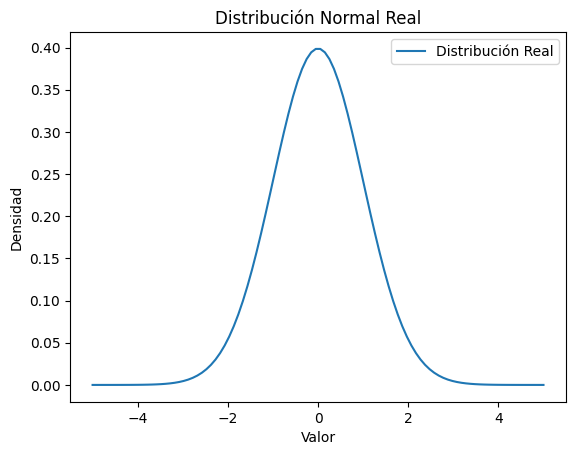

In [3]:
# Parámetros de la distribución real
mu_real = 0
sigma_real = 1

# Crear un rango de valores
x = np.linspace(-5, 5, 100)

# Crear la distribución normal real
p_real = norm.pdf(x, mu_real, sigma_real)

# Visualizar la distribución real
plt.plot(x, p_real, label="Distribución Real")
plt.title("Distribución Normal Real")
plt.xlabel("Valor")
plt.ylabel("Densidad")
plt.legend()
plt.show()

Ahora, utilizaremos la inferencia variacional para encontrar los parámetros de una distribución normal (media y desviación estándar) que mejor aproximen a la distribución real. Para ello, definimos una función de pérdida y utilizamos un algoritmo de optimización para ajustar los parámetros de nuestra distribución variacional:
- La función loss calcula la diferencia cuadrática entre la distribución real y la variacional. 
- La función minimize de scipy.optimize se usa para encontrar los valores de mu y sigma que minimizan esta pérdida.

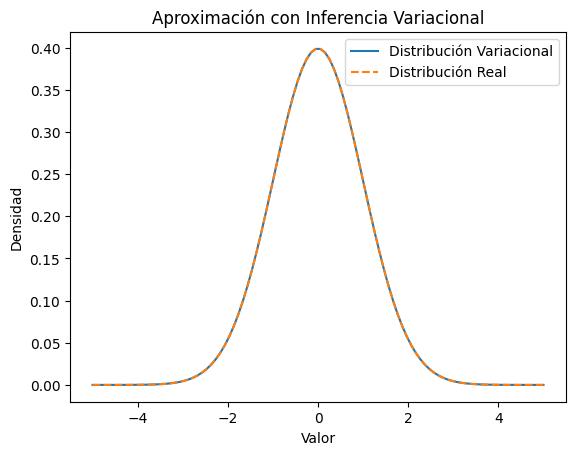

In [4]:
from scipy.optimize import minimize

# Inicializar parámetros de la distribución variacional
mu_variational = 1  # Valor inicial arbitrario
sigma_variational = 1  # Valor inicial arbitrario

# Función de pérdida (diferencia cuadrática entre las dos distribuciones)
def loss(params):
    mu, sigma = params
    p_variational = norm.pdf(x, mu, sigma)
    return np.sum((p_real - p_variational) ** 2)

# Optimización para encontrar los mejores parámetros
opt_result = minimize(loss, [mu_variational, sigma_variational])

# Obtener los parámetros optimizados
mu_opt, sigma_opt = opt_result.x

# Crear la distribución variacional con parámetros optimizados
p_variational_opt = norm.pdf(x, mu_opt, sigma_opt)

# Visualizar la distribución variacional
plt.plot(x, p_variational_opt, label="Distribución Variacional")
plt.plot(x, p_real, label="Distribución Real", linestyle='dashed')
plt.title("Aproximación con Inferencia Variacional")
plt.xlabel("Valor")
plt.ylabel("Densidad")
plt.legend()
plt.show()

## 2. Iris Dataset

Aplicaremos un modelo de mezcla gaussiana para agrupar los datos, usando inferencia variacional para estimar los parámetros del modelo.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.mixture import BayesianGaussianMixture

[5.1 3.5 1.4 0.2] 0
[4.9 3.  1.4 0.2] 0
[4.7 3.2 1.3 0.2] 0
[4.6 3.1 1.5 0.2] 0
[5.  3.6 1.4 0.2] 0


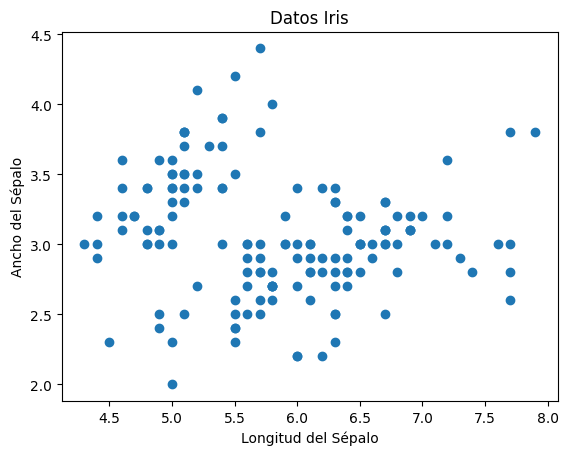

In [12]:
# Cargar el conjunto de datos Iris
iris = datasets.load_iris()
X = iris.data
Y = iris.target
for i in range(5):
    print(X[i], Y[i])

# Para simplificar, usaremos solo dos características
X = X[:, :2]

# Visualizar los datos
plt.scatter(X[:, 0], X[:, 1])
plt.title("Datos Iris")
plt.xlabel("Longitud del Sépalo")
plt.ylabel("Ancho del Sépalo")
plt.show()

Usaremos un modelo de mezcla gaussiana bayesiano:
- Un modelo de mezcla gaussiana asume que los datos provienen de una mezcla de varias distribuciones gaussianas (normales). Cada una de estas distribuciones se caracteriza por su media (centro del cluster) y su covarianza (forma del cluster). El modelo no solo busca estimar estos parámetros, sino también las proporciones de mezcla, es decir, cuánto contribuye cada distribución gaussiana a la mezcla total.
- La inferencia variacional es un método para aproximar las distribuciones posteriores complejas que resultan de modelos bayesianos. En contextos donde la inferencia exacta es computacionalmente inviable (como es a menudo el caso en modelos bayesianos con muchos parámetros), la inferencia variacional ofrece una solución práctica.

In [13]:
# Número de componentes (clusters) en la mezcla
n_components = 3

# Crear y ajustar el modelo de mezcla gaussiana
model = BayesianGaussianMixture(n_components=n_components,
                                covariance_type='full',
                                max_iter=1000,
                                init_params='random')
model.fit(X)

BayesianGaussianMixture(init_params='random', max_iter=1000, n_components=3)

Visualizamos los resultados del agrupamiento junto con los centros de cada cluster, cada punto se colorea según el cluster al que pertenece.

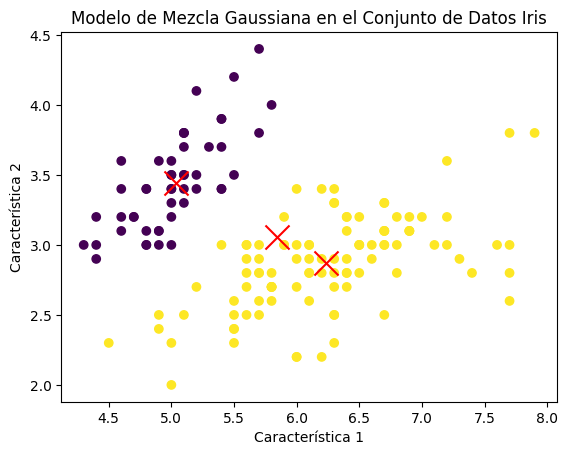

In [14]:
# Obtener las etiquetas de los clusters
labels = model.predict(X)

# Visualizar los resultados
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', marker='o')
plt.scatter(model.means_[:, 0], model.means_[:, 1], s=300, c='red', marker='x')
plt.title("Modelo de Mezcla Gaussiana en el Conjunto de Datos Iris")
plt.xlabel("Característica 1")
plt.ylabel("Característica 2")
plt.show()

La siguiente visualización de las distribuciones gaussianas aproximadas para el conjunto de datos Iris utilizando el modelo de mezcla gaussiana bayesiano (BayesianGaussianMixture). En el gráfico:

Los puntos grises representan las observaciones del conjunto de datos Iris, utilizando solo las dos primeras características para simplificar.
Las curvas de nivel representan las diferentes densidades de las distribuciones gaussianas estimadas por el modelo. Estas curvas muestran cómo el modelo ha aproximado las agrupaciones (clusters) en el conjunto de datos, donde cada curva corresponde a un nivel de densidad logarítmica negativa diferente.

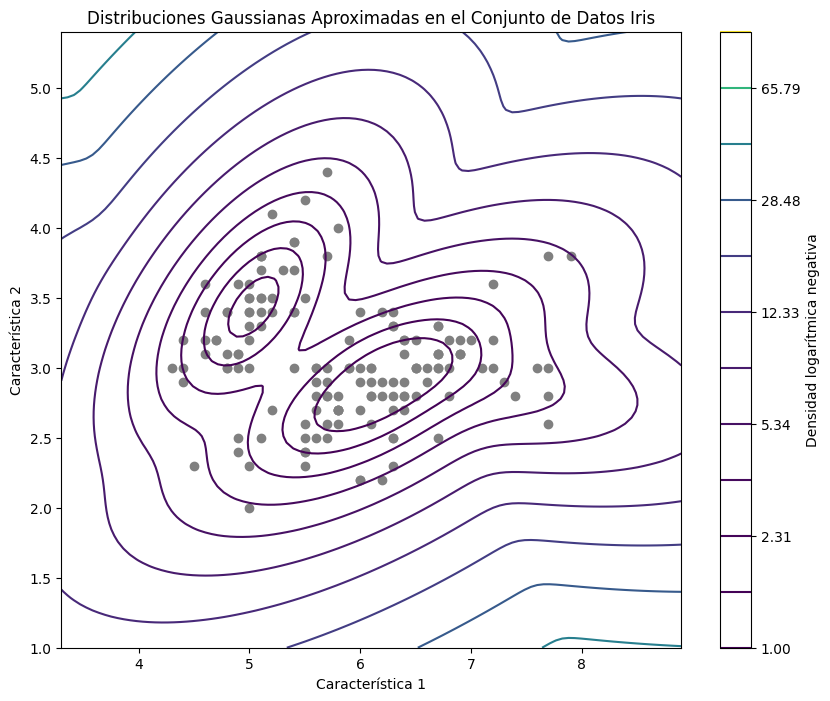

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.mixture import BayesianGaussianMixture

# Cargar el conjunto de datos Iris y seleccionar solo dos características para simplificar
iris = datasets.load_iris()
X = iris.data[:, :2]

# Crear y ajustar el modelo de mezcla gaussiana bayesiano
n_components = 3
model = BayesianGaussianMixture(n_components=n_components, covariance_type='full', random_state=0)
model.fit(X)

# Crear una malla de puntos para visualizar las distribuciones
x = np.linspace(X[:, 0].min() - 1, X[:, 0].max() + 1, 100)
y = np.linspace(X[:, 1].min() - 1, X[:, 1].max() + 1, 100)
X_mesh, Y_mesh = np.meshgrid(x, y)
XX = np.array([X_mesh.ravel(), Y_mesh.ravel()]).T

# Calcular la densidad logarítmica para cada punto en la malla
Z = -model.score_samples(XX)
Z = Z.reshape(X_mesh.shape)

# Visualización
plt.figure(figsize=(10, 8))
plt.scatter(X[:, 0], X[:, 1], c='gray', marker='o')
plt.contour(X_mesh, Y_mesh, Z, levels=np.logspace(0, 2, 12), cmap='viridis')
plt.title("Distribuciones Gaussianas Aproximadas en el Conjunto de Datos Iris")
plt.xlabel("Característica 1")
plt.ylabel("Característica 2")
plt.colorbar(label='Densidad logarítmica negativa')
plt.show()



## 3. MNIST Dataset

Para un ejemplo más avanzado y complejo, podemos usar un conjunto de datos de imágenes para aplicar un modelo de autoencoder variacional (VAE, por sus siglas en inglés). Los VAEs son especialmente adecuados para inferencia variacional debido a su capacidad para manejar espacios de alta dimensionalidad y aprender representaciones latentes complejas de los datos. Vamos a utilizar el conjunto de datos MNIST, que contiene imágenes de dígitos escritos a mano.

In [38]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda, Flatten, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import backend as K

In [39]:
# Hyperparameters
batch_size = 64
original_dim = 784  # 28*28, size of the MNIST images
latent_dim = 2  # Dimensionality of the latent space
intermediate_dim = 256
epochs = 50
epsilon_std = 1.0

El encoder mapea las entradas a un espacio latente. En este caso, las imágenes de MNIST se aplanan a un vector de 784 dimensiones y se pasan a través de una capa densa (fully connected) con función de activación ReLU. Luego se generan dos vectores, z_mean y z_log_var, que representan la media y el logaritmo de la varianza de la distribución latente respectivamente.

In [40]:
# Encoder
inputs = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)

La función de muestreo genera puntos en el espacio latente. Utiliza z_mean y z_log_var para muestrear de la distribución latente, aplicando la reparametrización truco para permitir la retropropagación.

In [41]:
# Sampling function
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    epsilon = K.random_normal(shape=(batch, dim), mean=0., stddev=epsilon_std)
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

z = Lambda(sampling)([z_mean, z_log_var])

El decoder mapea puntos del espacio latente de vuelta al espacio original de las imágenes. Se aplican capas densas con función de activación ReLU y luego una capa de salida con activación sigmoidea para reconstruir la imagen original.

In [42]:
# Decoder
decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)


Se crea el modelo VAE conectando el encoder y el decoder. Las entradas del modelo son las imágenes originales y las salidas son las imágenes reconstruidas.

In [43]:
# VAE model
vae = Model(inputs, x_decoded_mean)

La función de pérdida del VAE incluye dos términos: la pérdida de reconstrucción (diferencia entre la imagen original y la reconstruida) y la pérdida KL, que impone una regularización en la distribución latente para que se asemeje a una distribución normal. El modelo se compila con esta función de pérdida.

In [44]:
# Loss
reconstruction_loss = binary_crossentropy(inputs, x_decoded_mean) * original_dim
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)

In [45]:
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

Entrenamiento del modelo.

In [50]:
# Load MNIST dataset
(x_train, x_test), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((x_train.shape[0], original_dim))
x_test = x_test.reshape((x_test.shape[0], original_dim))

In [47]:
# Train
vae.fit(x_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, None))


Epoch 1/50
938/938 [==============================] - 5s 4ms/step - loss: 190.8749 - val_loss: 171.0536
Epoch 2/50
938/938 [==============================] - 6s 7ms/step - loss: 168.5898 - val_loss: 166.9646
Epoch 3/50
938/938 [==============================] - 6s 7ms/step - loss: 164.9420 - val_loss: 163.9340
Epoch 4/50
938/938 [==============================] - 5s 5ms/step - loss: 162.3075 - val_loss: 161.4191
Epoch 5/50
938/938 [==============================] - 6s 6ms/step - loss: 160.2750 - val_loss: 159.7877
Epoch 6/50
938/938 [==============================] - 6s 7ms/step - loss: 158.8367 - val_loss: 158.4336
Epoch 7/50
938/938 [==============================] - 6s 7ms/step - loss: 157.7531 - val_loss: 157.8115
Epoch 8/50
938/938 [==============================] - 6s 7ms/step - loss: 156.8475 - val_loss: 156.8914
Epoch 9/50
938/938 [==============================] - 5s 6ms/step - loss: 156.1155 - val_loss: 156.3386
Epoch 10/50
938/938 [==============================] - 6s 7ms/st

Se utiliza el encoder para mapear las imágenes de prueba al espacio latente y se visualiza este espacio, mostrando cómo el modelo ha organizado las diferentes clases de dígitos en este espacio latente.

157/157 [==============================] - 0s 2ms/step


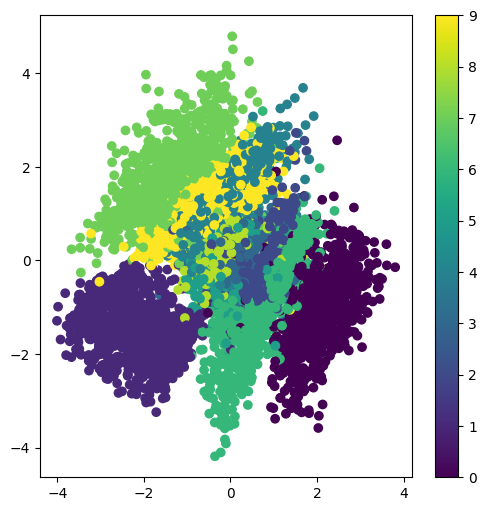

In [51]:
# Visualization of the latent space
encoder = Model(inputs, z_mean)

# Display a 2D plot of the digit classes in the latent space
x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
plt.figure(figsize=(6, 6))
plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], c=y_test)
plt.colorbar()
plt.show()

En el espacio latente, cada punto representa una imagen de dígito del conjunto de datos MNIST. Los colores representan las diferentes clases de dígitos (del 0 al 9).

Se puede observar cómo el VAE ha aprendido a organizar los dígitos en el espacio latente. Los dígitos que son similares entre sí tienden a agruparse cerca unos de otros, lo que indica que el VAE ha aprendido representaciones que capturan algunas de las características fundamentales de los dígitos. Por ejemplo, los dígitos "0" y "8" podrían estar cerca el uno del otro porque comparten similitudes en su forma circular.

La dispersión de los puntos sugiere cómo de bien el modelo puede separar o diferenciar entre las diferentes clases de dígitos. Si los grupos están bien definidos y hay poca superposición, el modelo es probablemente bueno para distinguir entre los diferentes dígitos. Si hay mucha superposición, el modelo puede tener dificultades para diferenciar entre ciertas clases de dígitos.

Esta visualización es una herramienta útil para comprender el rendimiento y las capacidades de un modelo VAE y para diagnosticar cómo podría mejorarse. Por ejemplo, si dos dígitos están consistentemente mezclados en el espacio latente, eso podría indicar que el modelo necesita ser más complejo o necesita ser entrenado por más tiempo para distinguir mejor entre esas clases.